In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, DenseNet201, InceptionV3, VGG16
from tensorflow.keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [2]:
df = pd.read_csv('../data-collection/dataset/skin_disease_dataset.csv')
df.head(5)

,disease_name,body_part,image_path,condition
0,acanthosis-nigricans,arm,../data-collection/dataset/data\acanthosis-nig...,Benign
1,acanthosis-nigricans,arm,../data-collection/dataset/data\acanthosis-nig...,Benign
2,acanthosis-nigricans,feet,../data-collection/dataset/data\acanthosis-nig...,Benign
3,acanthosis-nigricans,folds,../data-collection/dataset/data\acanthosis-nig...,Benign
4,acanthosis-nigricans,folds,../data-collection/dataset/data\acanthosis-nig...,Benign


In [3]:
le_disease = LabelEncoder()
df['disease_label'] = le_disease.fit_transform(df['disease_name'])

In [4]:
le_effect = LabelEncoder()
df['condition_label'] = le_effect.fit_transform(df['condition'])

In [5]:
class_counts = df['disease_name'].value_counts()
total_instances = len(df)
class_proportions = class_counts / total_instances

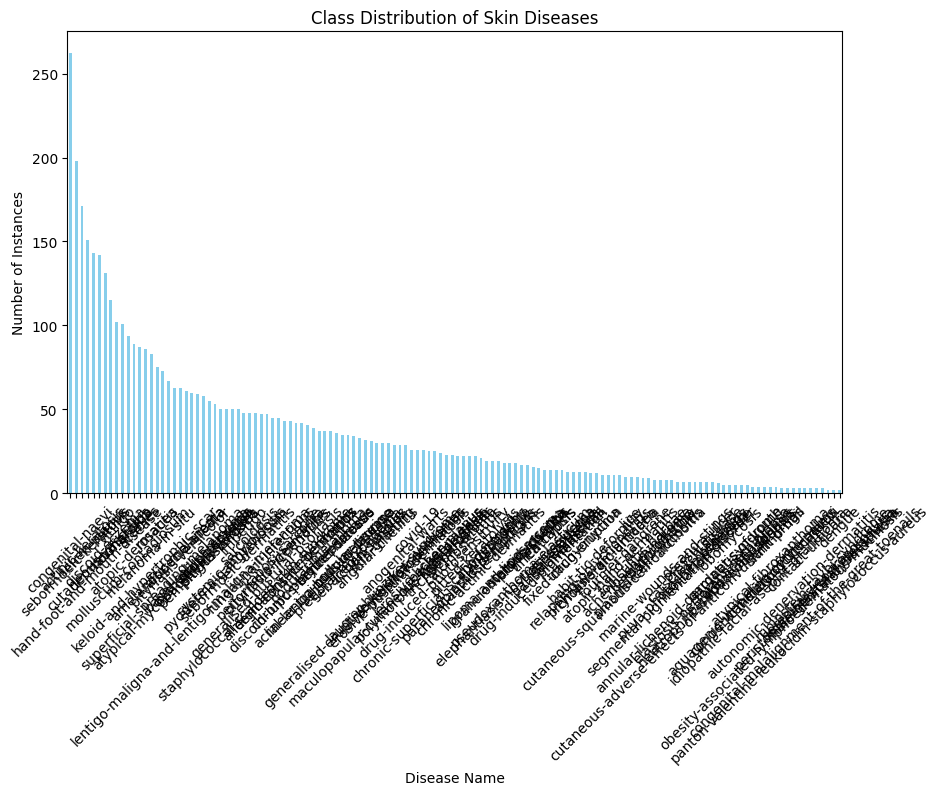

In [6]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Skin Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

In [7]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

In [8]:
images = np.array([load_and_preprocess_image(img_path) for img_path in df['image_path']])

In [12]:
feature_extractor = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
features = feature_extractor.predict(images)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, df['disease_label'])

In [ ]:
features_resampled, labels_resampled = shuffle(features_resampled, labels_resampled, random_state=42)

In [ ]:
y_resampled_cat = pd.get_dummies(labels_resampled).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_resampled, y_resampled_cat, test_size=0.2, random_state=42)

In [ ]:
input_shape = (features_resampled.shape[1],)
inputs = Input(shape=input_shape)

In [ ]:
base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model2 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Freeze base models
base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False

In [ ]:
# Get output tensors from base models
x1 = base_model1(inputs)
x2 = base_model2(inputs)
x3 = base_model3(inputs)

In [ ]:
# Global average pooling for each base model output
x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)
x3 = GlobalAveragePooling2D()(x3)

In [ ]:
# Concatenate the outputs
x = Concatenate()([x1, x2, x3])

x = Dense(512, activation='relu')(inputs)
x = Dropout(0.5)(x)

In [ ]:
# Add output layer
outputs = Dense(len(le_disease.classes_), activation='softmax')(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Train the model using the extracted features
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=le_disease.classes_))

In [ ]:
model.save('best_model_3.h5')